Configure

In [92]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim 
from torchvision import datasets , transforms
from torchvision import models
from torchvision.models import VGG19_Weights
from torch.utils.data import DataLoader 
import torchvision.utils
import matplotlib.pyplot as plt 
import numpy as np 

In [93]:
BATCH_SIZE = 128 
LR = 1e-3
EPOCHS = 60
LATENT_DIM = 128
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


Data Pipelining 

In [94]:
transform = transforms.Compose (
    [
        transforms.ToTensor()
     ]
)

train_dataset = datasets.CIFAR10(root = './data' , train = True , download = False , transform = transform)
train_loader =  DataLoader(train_dataset , batch_size = BATCH_SIZE , shuffle = True)

test_dataset = datasets.CIFAR10(root = './data' , train = False , download =  False , transform = transform)
test_loader = DataLoader(test_dataset , batch_size = BATCH_SIZE , shuffle = True)



VAE 

In [95]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim 

        self.encoder = nn.Sequential(
            self.conv_block(3,32),
            self.conv_block(32,64),
            self.conv_block(64,128),
            self.conv_block(128,256)
        )
        
        # This now matches 256 * 2 * 2 = 1024
        self.flatten_size = 256 * 2 * 2
        self.fc_mu = nn.Linear(self.flatten_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_size, latent_dim)
        self.fc_input = nn.Linear(latent_dim, self.flatten_size)

        self.decoder = nn.Sequential(
           self.upsample_block(256,128),
           self.upsample_block(128,64),
           self.upsample_block(64,32),
           self.upsample_block(32,16),

           nn.Conv2d(16,3 , kernel_size = 3 ,stride = 1 , padding = 1),
           nn.Sigmoid()
           
        )


    def conv_block(self , in_channels , out_channels ):
        return nn. Sequential(
            nn.Conv2d(in_channels = in_channels , out_channels = out_channels , kernel_size = 3 , stride = 2 , padding = 1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )
    
    def upsample_block(self , in_channels , out_channels):
        return nn.Sequential(
            nn.Upsample(scale_factor = 2 , mode = 'bilinear' , align_corners =  True),
            nn.Conv2d(in_channels = in_channels , out_channels = out_channels , kernel_size = 3 , stride = 1 , padding = 1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )
    

    def reparameterization(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std   
        else:
            return mu

    def forward(self , x):
        h = self.encoder(x)
        h = torch.flatten( h , start_dim = 1)
        mu , logvar = self.fc_mu(h) , self.fc_logvar(h)

        z = self.reparameterization(mu , logvar)

        z_proj = self.fc_input(z).view(-1 , 256 , 2 ,2)

        return self.decoder(z_proj) , mu , logvar

Perceptual Loss

In [96]:
class Perceptualloss(nn.Module):
    def __init__(self):
        super(Perceptualloss, self).__init__()
        # Use earlier layers (up to relu3_3) for better structural similarity
        vgg = models.vgg19(weights=VGG19_Weights.DEFAULT).features
        self.features = nn.Sequential(*list(vgg.children())[:16]).eval()
        
        for param in self.features.parameters():
            param.requires_grad = False

        # Registering as buffers ensures they move to the GPU with the module
        self.register_buffer('mean', torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer('std', torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

    def forward(self, recon, x):
        # Now self.mean and self.std will be on the same device as recon and x
        recon = (recon - self.mean) / self.std
        x = (x - self.mean) / self.std
        
        return F.mse_loss(self.features(recon), self.features(x))

Total Loss

In [97]:
# Create the loss instance and move it to GPU
perceptual_loss_fn = Perceptualloss().to(DEVICE)

# Then define your calculation function
def calculate_loss(recon_x, x, mu, logvar, beta=0.01):
    p_loss = perceptual_loss_fn(recon_x, x)
    mse_loss = F.mse_loss(recon_x, x)
    
    # KLD Loss
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kld_loss /= x.size(0)
    
    # Summing the components
    return mse_loss + (1.0 * p_loss) + (beta * kld_loss)

Training Loop

In [98]:
model = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)

print("Starting Training...")

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0
    
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(DEVICE)
        
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        
        loss = calculate_loss(recon_batch, data, mu, logvar)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    avg_loss = train_loss / len(train_loader)
    print(f'Epoch {epoch}/{EPOCHS} \t Loss: {avg_loss:.5f}')

print("Training Complete.")

Starting Training...
Epoch 1/60 	 Loss: 29.42839
Epoch 2/60 	 Loss: 24.77584
Epoch 3/60 	 Loss: 22.72993
Epoch 4/60 	 Loss: 21.49956
Epoch 5/60 	 Loss: 20.65468
Epoch 6/60 	 Loss: 20.00749
Epoch 7/60 	 Loss: 19.46426
Epoch 8/60 	 Loss: 19.01116
Epoch 9/60 	 Loss: 18.63885
Epoch 10/60 	 Loss: 18.33969
Epoch 11/60 	 Loss: 18.05993
Epoch 12/60 	 Loss: 17.82455
Epoch 13/60 	 Loss: 17.60227
Epoch 14/60 	 Loss: 17.42283
Epoch 15/60 	 Loss: 17.25766
Epoch 16/60 	 Loss: 17.12142
Epoch 17/60 	 Loss: 16.98428
Epoch 18/60 	 Loss: 16.88040
Epoch 19/60 	 Loss: 16.77451
Epoch 20/60 	 Loss: 16.67971
Epoch 21/60 	 Loss: 16.56921
Epoch 22/60 	 Loss: 16.48350
Epoch 23/60 	 Loss: 16.41746
Epoch 24/60 	 Loss: 16.34231
Epoch 25/60 	 Loss: 16.26720
Epoch 26/60 	 Loss: 16.19450
Epoch 27/60 	 Loss: 16.14082
Epoch 28/60 	 Loss: 16.08015
Epoch 29/60 	 Loss: 16.00736
Epoch 30/60 	 Loss: 15.94606
Epoch 31/60 	 Loss: 15.92086
Epoch 32/60 	 Loss: 15.86476
Epoch 33/60 	 Loss: 15.81738
Epoch 34/60 	 Loss: 15.76628
Ep

Visualization

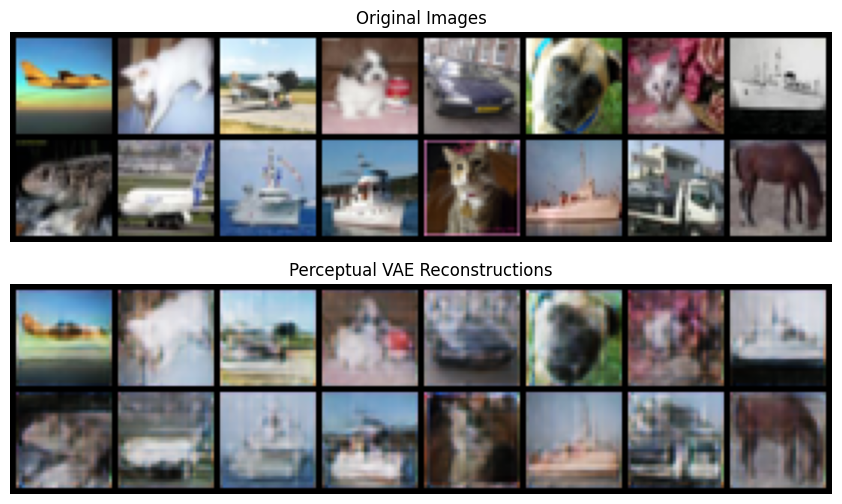

In [99]:
def visualize_results(model):
    model.eval()
    
    # 1. Reconstructions
    data, _ = next(iter(test_loader))
    data = data.to(DEVICE)
    with torch.no_grad():
        recon, _, _ = model(data)
    
    data = data.cpu()
    recon = recon.cpu()
    
    plt.figure(figsize=(12, 6))
    
    # Show Original
    plt.subplot(2, 1, 1)
    grid_data = torchvision.utils.make_grid(data[:16], nrow=8)
    plt.imshow(grid_data.permute(1, 2, 0))
    plt.title("Original Images")
    plt.axis("off")
    
    # Show Reconstruction
    plt.subplot(2, 1, 2)
    grid_recon = torchvision.utils.make_grid(recon[:16], nrow=8)
    plt.imshow(grid_recon.permute(1, 2, 0))
    plt.title("Perceptual VAE Reconstructions")
    plt.axis("off")
    plt.show()

visualize_results(model)